In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.loc[0]

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               22.0
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object

In [5]:
# drop delle colonne che non servono alla predizione
train_data.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Split dei dati di addestramento in fetures (X) ed etichetta obiettivo (y)


In [6]:
X = train_data.drop('Survived', axis=1, inplace=False)
y = train_data['Survived']

X.shape, y.shape

((891, 7), (891,))

## Normalizzazione, standardizzazione e riempimento dei vuoi

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


'''
Pipeline per la trasformazione dei dati numerici:
1. Riempio i campi mancanti con la mediana degli altri valori
2. Scalo tutti i valori per ridurli all'intervallo 0-1
'''

numeric_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())]
    
)

'''
Pipeline per i valori testuali (categorici):
1. riempie i valori vuoti con il valore più frequente
2- one-hot ecoding
'''

categorical_pipeline = Pipeline(
    [('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder())]
)


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [9]:
# attribuisco le pipeline
from sklearn.compose import ColumnTransformer



numeric_attributes = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_attributes = ['Pclass', 'Sex', 'Embarked']

full_pipeline = ColumnTransformer([("num", numeric_pipeline, numeric_attributes), 
                                   ("cat", categorical_pipeline, categorical_attributes)])

X = full_pipeline.fit_transform(X)
X.shape

(891, 12)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 12), (179, 12), (712,), (179,))

## Creazione del modello

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# creazione del modello

titanic_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(12,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
])

titanic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6656      
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 6

In [13]:
'''
callback per fermare l'addestramento quando l'accuratezza arriva all'83%
'''

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.93):
            print("\nReached 83% accuracy so cancelling training!")
            self.model.stop_training = True

In [14]:
# compilazione del modello
titanic_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

# fit del modello per 100 epoche
history = titanic_model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=8, 
                    callbacks=[myCallback()],
                    epochs=100)

Epoch 1/100
89/89 [==============================] - 3s 11ms/step - loss: 9.9287 - accuracy: 0.6250 - val_loss: 8.4429 - val_accuracy: 0.6480
Epoch 2/100
89/89 [==============================] - 1s 8ms/step - loss: 7.2804 - accuracy: 0.7051 - val_loss: 6.2360 - val_accuracy: 0.8212
Epoch 3/100
89/89 [==============================] - 1s 8ms/step - loss: 5.4292 - accuracy: 0.8188 - val_loss: 4.7108 - val_accuracy: 0.7989
Epoch 4/100
89/89 [==============================] - 1s 8ms/step - loss: 4.1505 - accuracy: 0.8104 - val_loss: 3.6435 - val_accuracy: 0.8045
Epoch 5/100
89/89 [==============================] - 1s 8ms/step - loss: 3.2545 - accuracy: 0.8118 - val_loss: 2.9021 - val_accuracy: 0.8212
Epoch 6/100
89/89 [==============================] - 1s 8ms/step - loss: 2.6178 - accuracy: 0.8188 - val_loss: 2.3708 - val_accuracy: 0.8045
Epoch 7/100
89/89 [==============================] - 1s 8ms/step - loss: 2.1693 - accuracy: 0.8244 - val_loss: 1.9878 - val_accuracy: 0.8268
Epoch 8/100


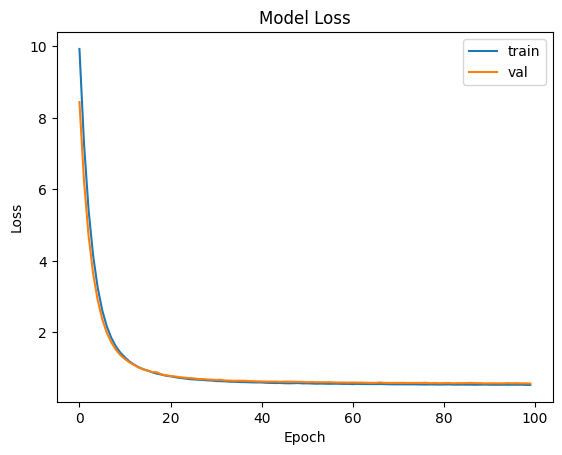

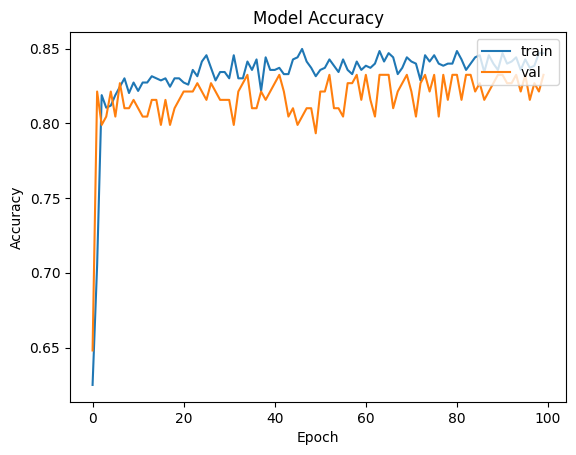

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Preparazione dei dati di test

In [16]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
# preparazione dei dati di test
test_data.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1, inplace=True)
test_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [18]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Sottoporre i dati di test alla stessa pipeline dei dati di addestramento

In [19]:
test_pipelined = full_pipeline.transform(test_data)
test_pipelined.shape

(418, 12)

In [20]:
X[0], test_pipelined[0]

(array([-0.56573646,  0.43279337, -0.47367361, -0.50244517,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ]),
 array([ 0.39488658, -0.4745452 , -0.47367361, -0.49078316,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ]))

In [21]:
test_pipelined[0]

array([ 0.39488658, -0.4745452 , -0.47367361, -0.49078316,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ])

In [22]:
preds = titanic_model.predict(test_pipelined)
preds[:10]

14/14 [==============================] - 0s 2ms/step


array([[0.11917171],
       [0.53185284],
       [0.16798739],
       [0.1208823 ],
       [0.4181256 ],
       [0.21019496],
       [0.6812977 ],
       [0.16066888],
       [0.64519924],
       [0.12332714]], dtype=float32)

In [23]:
train_pred = titanic_model.predict(X_train)
train_pred[:10]

23/23 [==============================] - 0s 3ms/step


array([[0.21721287],
       [0.1368122 ],
       [0.11337026],
       [0.11864515],
       [0.21085133],
       [0.3179304 ],
       [0.216834  ],
       [0.17290756],
       [0.11924157],
       [0.2854475 ]], dtype=float32)

In [24]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission['Survived'] = [0 if pred < 0.5 else 1 for pred in preds]
submission[:20]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [25]:
from IPython.display import FileLink


submission.to_csv('submission.csv',index=False)
FileLink(r'submission.csv')

/kaggle/working/submission.csv